### 데이터 전처리


In [124]:
from util import preprocessing_simple_train
from util import month_to_day, make_mean
import pandas as pd
import numpy as np

mean_df = preprocessing_simple_train("fast")
tmp = month_to_day(mean_df['rainfall_train.ef_month']) + mean_df['rainfall_train.ef_day'] 

mean_df['daysin'] = np.sin(tmp)
mean_df['daycos'] = np.cos(tmp)
mean_df['day'] = tmp
mean_df = make_mean(mean_df,15)
raw_df = pd.read_csv('./data/rainfall_train.csv').drop(columns=['Unnamed: 0'])
raw_df = raw_df[raw_df['rainfall_train.class_interval'] != -999]
for i in range(1,9):
    raw_df[f'rainfall_train.v0{i}'] -= raw_df[f'rainfall_train.v0{i+1}']
    raw_df[f'rainfall_train.v0{i}'] /= 100.0
raw_df[f'rainfall_train.v09'] /= 100.0

r_df = raw_df[['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour','rainfall_train.class_interval']]


### 테스트/ 검증 데이터 결정
####  테스트데이터

In [203]:
from util import make_day2class, make_day2freqclass
import pandas as pd 

_year = "A"

train_df = mean_df[mean_df['rainfall_train.ef_year'] != _year].reset_index(drop=True)
test_df = mean_df[mean_df['rainfall_train.ef_year'] == _year].reset_index(drop=True)
rtrain_df = r_df[r_df['rainfall_train.ef_year'] != _year].reset_index(drop=True)
rtest_df = r_df[r_df['rainfall_train.ef_year'] == _year].reset_index(drop=True)
raw_train_df =  raw_df[raw_df['rainfall_train.ef_year'] != _year].reset_index(drop=True)
raw_test_df =  raw_df[raw_df['rainfall_train.ef_year'] == _year].reset_index(drop=True)



day2class = make_day2class(train_df)
day2freqclass = make_day2freqclass(train_df)

day2class=day2class.rename(columns={"rainfall_train.class_interval":"mean_class"})
day2freqclass=day2freqclass.rename(columns={"rainfall_train.class_interval":"freq_class"})
train_df = pd.merge(train_df,day2class,how="left",on=['day']).copy()
train_df = pd.merge(train_df,day2freqclass,how="left",on=['day']).copy()
train_df['freq_class'] = train_df['freq_class'].fillna(0)
test_df = pd.merge(test_df,day2class,how="left",on=['day']).copy()
test_df = pd.merge(test_df,day2freqclass,how="left",on=['day']).copy()
test_df['freq_class'] = test_df['freq_class'].fillna(0)


#### 제출용 데이터

In [117]:
from util import make_day2class
import pandas as pd 
day2class = make_day2class(mean_df)
day2class=day2class.rename(columns={"rainfall_train.class_interval":"mean_class"})
day2freqclass = make_day2freqclass(train_df)
day2freqclass=day2freqclass.rename(columns={"rainfall_train.class_interval":"freq_class"})
train_df = pd.merge(mean_df,day2class,how="left",on=['day']).copy()
train_df = pd.merge(train_df,day2freqclass,how="left",on=['day']).copy()
raw_train_df =  raw_df



### 무강수/강수 데이터 만들기

In [204]:
X = train_df.drop(columns=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.vv","rainfall_train.class_interval",'v_max','v_median','day','freq_class','rainfall_train.dh_x'])
X['rainfall_train.ef_hour'] /= 24.0
Y = train_df["rainfall_train.class_interval"]
X_V = test_df.drop(columns=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.vv","rainfall_train.class_interval",'v_max','v_median','day','freq_class','rainfall_train.dh_x'])
X_V['rainfall_train.ef_hour'] /= 24.0
Y_V = test_df["rainfall_train.class_interval"]

## 강수/무강수 분류

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
m_b = ExtraTreesClassifier(n_estimators= 175, criterion = 'log_loss', max_depth = 12,max_leaf_nodes = 45, random_state=42) 
m_b.fit(X,Y==0)
Y_prev = m_b.predict(X_V)
print(f"무강수/강수 분류 accuracy_score: {accuracy_score(Y_V==0,Y_prev)}")

무강수/강수 분류 accuracy_score: 0.906523591849384


## 강수 계급  데이터

In [206]:
ctrain_df = train_df[train_df['rainfall_train.class_interval'] != 0]
ctest_df = test_df[test_df['rainfall_train.class_interval'] != 0]

raw_test_df = raw_test_df[raw_test_df['rainfall_train.class_interval'] != 0]
raw_test_df = raw_test_df[['rainfall_train.dh','rainfall_train.stn4contest','rainfall_train.ef_year', 'rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour','rainfall_train.class_interval','rainfall_train.v01',
       'rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04',
       'rainfall_train.v05', 'rainfall_train.v06', 'rainfall_train.v07',
       'rainfall_train.v08', 'rainfall_train.v09']]
raw_test_df = pd.merge(raw_test_df,ctest_df.drop(columns=['rainfall_train.class_interval','rainfall_train.dh_x','rainfall_train.v01',
       'rainfall_train.v02', 'rainfall_train.v03', 'rainfall_train.v04',
       'rainfall_train.v05', 'rainfall_train.v06', 'rainfall_train.v07',
       'rainfall_train.v08', 'rainfall_train.v09']),on=['rainfall_train.stn4contest','rainfall_train.ef_year', 'rainfall_train.ef_month',
       'rainfall_train.ef_day','rainfall_train.ef_hour'])

CX = ctrain_df.drop(columns=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.vv","rainfall_train.class_interval",'v_max','day','daysin','daycos','mean_vmax','v_median','rainfall_train.v00','freq_class','rainfall_train.dh_x'])
CX['rainfall_train.ef_hour'] /= 24.0
CY = ctrain_df["rainfall_train.class_interval"]
CX_V = ctest_df.drop(columns=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.vv","rainfall_train.class_interval",'v_max','day','daysin','daycos','mean_vmax','v_median','rainfall_train.v00','freq_class','rainfall_train.dh_x'])
CX_V['rainfall_train.ef_hour'] /= 24.0
CY_V = ctest_df["rainfall_train.class_interval"]


RX_V = raw_test_df.drop(columns=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.vv","rainfall_train.class_interval",'v_max','day','daysin','daycos','mean_vmax','v_median','rainfall_train.v00','freq_class','rainfall_train.dh'])
RX_V['rainfall_train.ef_hour'] /= 24.0
RY_V = raw_test_df["rainfall_train.class_interval"]

In [207]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from util import compute_csi
m_c = ExtraTreesClassifier(n_estimators=150,random_state=42,max_depth=11,criterion='gini')
m_c.fit(CX,CY)
CY_prev =m_c.predict(CX_V)
RY_prev =m_c.predict(RX_V)
print(f"train_DH 최소 : {compute_csi(CY,m_c.predict(CX))}")
print(f"valid_DH 최소 : {compute_csi(CY_V,CY_prev)}")

train_DH 최소 : 0.6008700380641653
valid_DH 최소 : 0.2546436285097192


In [209]:
raw_test_df['cprev'] = RY_prev
ctest_df = pd.merge(ctest_df,raw_test_df.groupby(by=['rainfall_train.stn4contest', 'rainfall_train.ef_year',
       'rainfall_train.ef_month', 'rainfall_train.ef_day',
       'rainfall_train.ef_hour'])['cprev'].apply(lambda x: np.argmax(np.bincount(np.array(x)))).reset_index(),how='left',on=['rainfall_train.stn4contest', 'rainfall_train.ef_year',
       'rainfall_train.ef_month', 'rainfall_train.ef_day','rainfall_train.ef_hour'])
CY_prev2 = np.where(ctest_df['rainfall_train.dh_x'] >100,ctest_df['cprev'],CY_prev)
ctest_df= ctest_df.drop(columns=['cprev'])
print(f"DH 최소 : {compute_csi(CY_V,CY_prev2)}")

DH 최소 : 0.2546436285097192


## 전체 CSI 점수 검증


In [107]:
test_df['prev'] = 0
ctest_df['cprev'] = CY_prev
rtest_df = pd.merge(rtest_df, test_df.loc[Y_prev,['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour','prev']], how="left" , on=['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour'])
rtest_df = pd.merge(rtest_df, ctest_df[['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour','cprev']], how="left" , on=['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour'])
rtest_df['prev'] = rtest_df['cprev'].combine_first(rtest_df['prev'])
rtest_df['prev'] = rtest_df['prev'].fillna(1)


/tmp/ipykernel_9141/503635885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctest_df['cprev'] = CY_prev


In [108]:
print(f"최종 CSI : {compute_csi(rtest_df['rainfall_train.class_interval'], rtest_df['prev'])}")

최종 CSI : 0.22045571307571613


['rainfall_train.ef_hour' 'rainfall_train.v01' 'rainfall_train.v02'
 'rainfall_train.v03' 'rainfall_train.v04' 'rainfall_train.v05'
 'rainfall_train.v06' 'rainfall_train.v07' 'rainfall_train.v08'
 'rainfall_train.v09' 'mean_vmedian' 'mean_class']
[0.06537141 0.06255466 0.08733331 0.07838484 0.08519994 0.11026147
 0.12026755 0.09730283 0.04808502 0.024892   0.11968886 0.10065813]


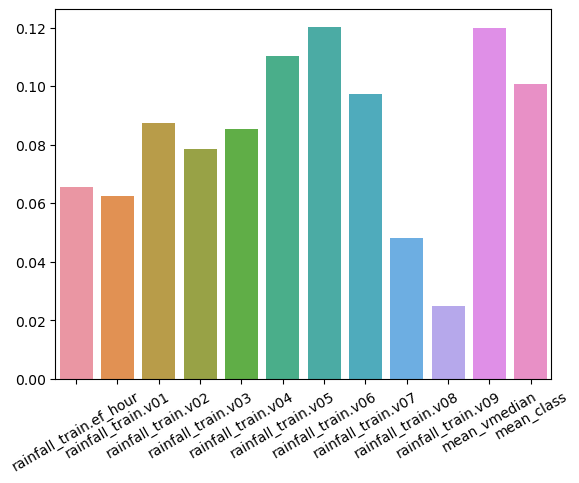

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x=CX_V.columns.values,y=m_c.feature_importances_)
plt.xticks(rotation=30)
print(CX_V.columns.values)
print(m_c.feature_importances_)

### 제출

In [370]:
from util import preprocessing_simple_test

RAW= pd.read_csv("./data/rainfall_test.csv").drop(columns=["Unnamed: 0"])
TEST =preprocessing_simple_test()
TEST['rainfall_test.ef_hour'] /= 24.0
TEST['day'] = month_to_day(TEST["rainfall_test.ef_month"]) + TEST["rainfall_test.ef_day"]
TEST['daysin'] = np.sin(np.pi*2*(TEST['day']/365.0))
TEST['daycos'] = np.cos(np.pi*2*(TEST['day']/365.0))
TEST.columns = TEST.columns.str.replace("rainfall_test","rainfall_train")
TEST = make_mean(TEST)
TEST = pd.merge(TEST,day2class,how="left",on=['day'])
X=TEST.drop(columns=['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','v_max','v_median','day','rainfall_train.class_interval','rainfall_train.dh_x'])
b_pred = m_b.predict(X)
CTEST = TEST[~b_pred].reset_index(drop=True)
CTEST.columns = CTEST.columns.str.replace("rainfall_train","rainfall_test")
CTEST['rainfall_test.ef_hour'] *= 24.0


In [371]:
CTEST = pd.merge(RAW, CTEST[['rainfall_test.stn4contest','rainfall_test.ef_year', 'rainfall_test.ef_month',
       'rainfall_test.ef_day', 'rainfall_test.ef_hour','mean_vmedian','mean_class']], how='inner',on=['rainfall_test.stn4contest','rainfall_test.ef_year', 'rainfall_test.ef_month',
       'rainfall_test.ef_day', 'rainfall_test.ef_hour'])
CTEST['rainfall_test.ef_hour'] /= 24.0
CTEST.columns = CTEST.columns.str.replace("rainfall_test","rainfall_train")
X = CTEST.drop(columns=['rainfall_train.fc_year', 'rainfall_train.fc_month',
       'rainfall_train.fc_day', 'rainfall_train.fc_hour', 'rainfall_train.dh','rainfall_train.class_interval','rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day'])
CTEST['class'] = m_c.predict(X)

In [372]:
CTEST = CTEST.groupby(by=['rainfall_train.stn4contest','rainfall_train.ef_year', 'rainfall_train.ef_month',
       'rainfall_train.ef_day', 'rainfall_train.ef_hour'])['class'].apply(lambda x: np.argmax(np.bincount(np.array(x)))).reset_index()

In [373]:
TEST.loc[b_pred, 'rainfall_train.class_interval'] = 0
tmp_df = pd.merge(TEST,CTEST[['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour','class']],how='left',on=['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour'])
tmp_df['rainfall_train.class_interval'] = tmp_df['class'].combine_first(tmp_df['rainfall_train.class_interval'])
tmp_df['rainfall_train.ef_hour'] *= 24
tmp_df['rainfall_train.ef_hour'] = tmp_df['rainfall_train.ef_hour'].astype(int)
tmp_df.drop(columns=['class'],inplace=True)
tmp_df = tmp_df.rename(columns={'rainfall_train.class_interval':'class'})
tmp_df.columns = tmp_df.columns.str.replace("rainfall_train", "rainfall_test")

In [374]:
ind = RAW['rainfall_test.class_interval'] == -999
tt_df = pd.merge(RAW,tmp_df[['rainfall_test.stn4contest','rainfall_test.ef_year','rainfall_test.ef_month','rainfall_test.ef_day','rainfall_test.ef_hour','class']],how='left',on=['rainfall_test.stn4contest','rainfall_test.ef_year','rainfall_test.ef_month','rainfall_test.ef_day','rainfall_test.ef_hour'])
RAW['rainfall_test.class_interval']=tt_df['class'].combine_first(tt_df['rainfall_test.class_interval'])
RAW['rainfall_test.class_interval'] = RAW['rainfall_test.class_interval'].astype(int)
RAW.loc[ind,'rainfall_test.class_interval'] = -999

#### 제출파일 검증

In [375]:
RAW['rainfall_test.class_interval'].value_counts()

rainfall_test.class_interval
 0      103599
 5       10020
 2        4922
 6        2166
 4         642
 3         402
-999       130
 1          71
 7          48
Name: count, dtype: int64

In [376]:
RAW.to_csv('./data/240198.csv',index=False,encoding='euc-kr')